In [2]:
from walidacja_funkcji import *
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import wasserstein_distance

In [3]:
def reinit_model(model):
    """Reinicjalizuje wagi modelu"""
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

def fast_kl_jsd_2d(real_data, fake_data, bins=50):
    all_data = np.vstack([real_data, fake_data])
    range_2d = [(all_data[:, i].min(), all_data[:, i].max()) for i in range(all_data.shape[1])]
    
    # Histogramy w jednej operacji
    P, _ = np.histogramdd(real_data, bins=bins, range=range_2d, density=True)
    Q, _ = np.histogramdd(fake_data, bins=bins, range=range_2d, density=True)
    
    # Normalizacja do prawdopodobieństw
    P = P / P.sum()
    Q = Q / Q.sum()
    
    # Epsilon dla stabilności numerycznej
    epsilon = 1e-8
    P += epsilon
    Q += epsilon
    
    # KL divergence: KL(Q||P) - fake vs real
    kl_divergence = np.sum(Q * np.log(Q / P))
    
    # JSD: 0.5 * [KL(P||M) + KL(Q||M)], gdzie M = (P+Q)/2
    M = (P + Q) / 2 + epsilon
    
    kl_pm = np.sum(P * np.log(P / M))
    kl_qm = np.sum(Q * np.log(Q / M))
    jsd = 0.5 * (kl_pm + kl_qm)
    
    return kl_divergence, jsd

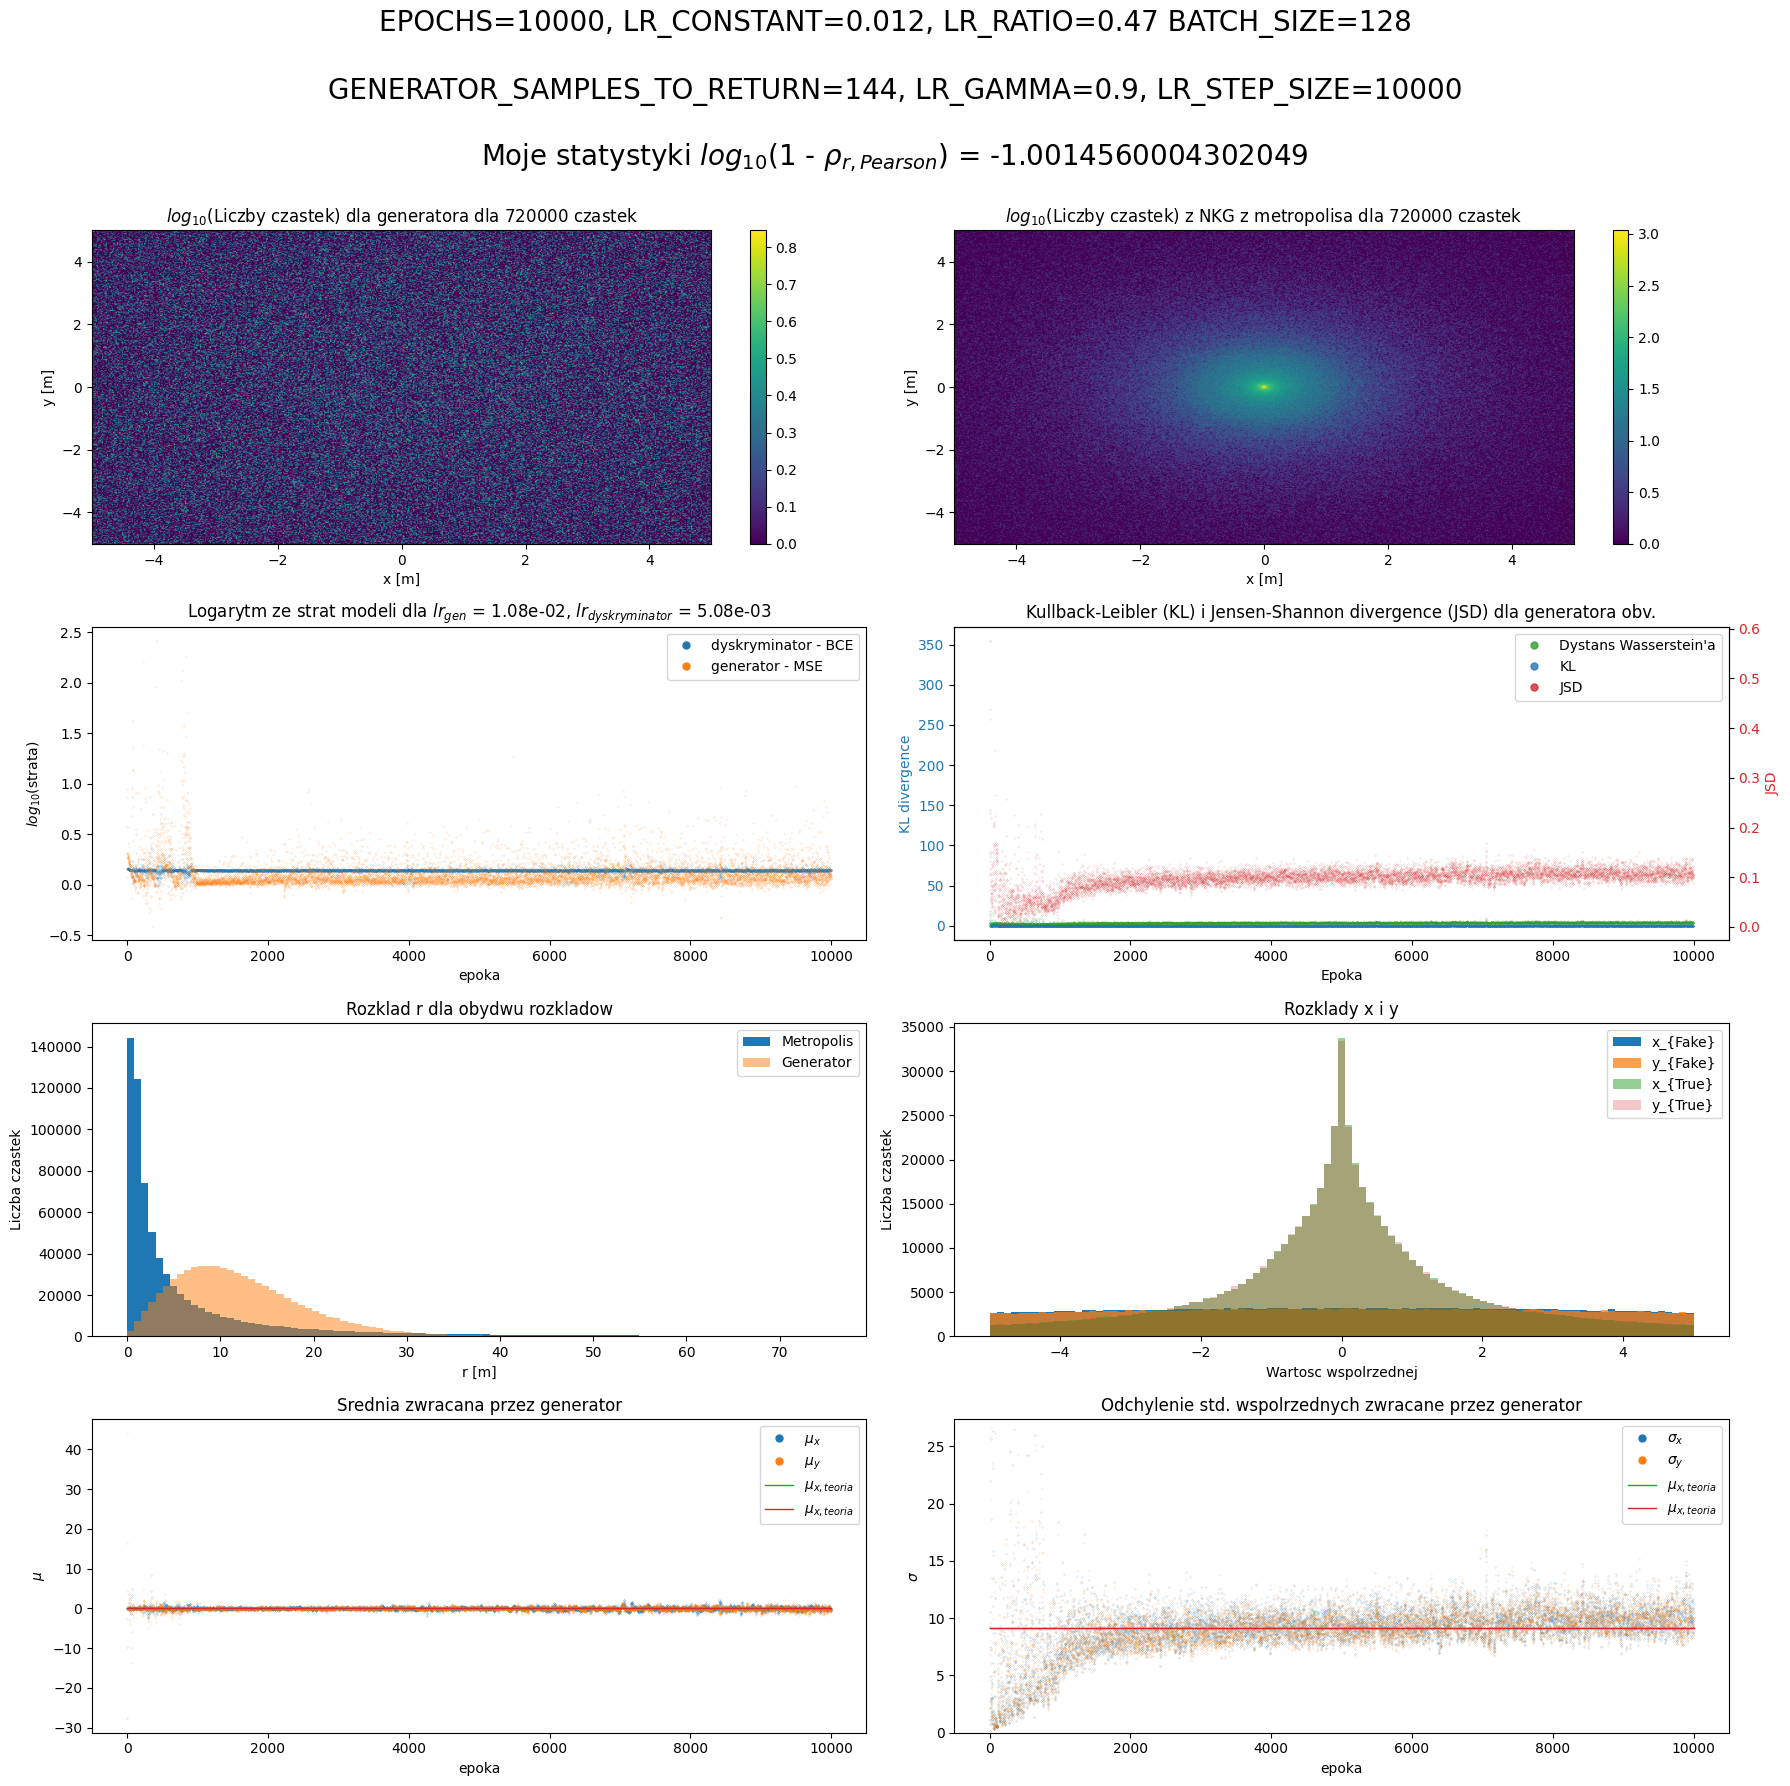

In [87]:
prober = rs_prober_NKG()

def get_2d_data(PROBE_SIZE: int):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2, epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0)
    theta = np.random.uniform(0, 2*np.pi, size=PROBE_SIZE // 2)
    xs = rs * np.cos(theta)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys])

def plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, LR_GAMMA, LR_STEP_SIZE, epoch, extra_label = ''):
    _, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(18, 20))
    SAMPLE_LENGTH = GENERATOR_SAMPLES_TO_RETURN * 10000
    ROI = np.array([[-5, 5], [-5, 5]])
    epoch_range = np.arange(epoch)

    x_true, y_true = get_2d_data(SAMPLE_LENGTH)
    hist_true, x_true_edges, y_true_edges = np.histogram2d(x_true, y_true, bins=500, range=ROI)
    hist_true += 1

    noise = torch.randn(SAMPLE_LENGTH // GENERATOR_SAMPLES_TO_RETURN, LATENT_DIM).cuda()
    x_fake, y_fake = generator.layers(noise).detach().reshape(-1, 2).cpu().numpy().T
    hist_fake, x_fake_edges, y_fake_edges = np.histogram2d(x_fake, y_fake, bins=500, range=ROI)
    hist_fake += 1 # zeby sie logarytm nie wywalil

    # Wykres 1: Hisogram z generatora
    ax1.set_title(rf'$log_{{10}}$(Liczby czastek) dla generatora dla {SAMPLE_LENGTH // 2} czastek')
    im = ax1.imshow(np.log10(hist_fake).T, extent=ROI.flatten(), aspect='auto')
    plt.colorbar(im, ax=ax1)
    ax1.set_xlabel('x [m]')
    ax1.set_ylabel('y [m]')

    # Wykres 2: Histogram danych prawdziwych 
    ax2.set_title(rf'$log_{{10}}$(Liczby czastek) z NKG z metropolisa dla {SAMPLE_LENGTH // 2} czastek')
    im = ax2.imshow(np.log10(hist_true).T, extent=ROI.flatten(), aspect='auto')
    plt.colorbar(im, ax=ax2)
    ax2.set_xlabel('x [m]')
    ax2.set_ylabel('y [m]')

    # Wykres 3: Straty
    markersize = min(1000 / len(discriminator_losses), 10)
    ax3.set_title(rf'Logarytm ze strat modeli dla $lr_{{gen}}$ = {generator.optim.param_groups[0]["lr"]:.2e}, $lr_{{dyskryminator}}$ = {discriminator.optim.param_groups[0]["lr"]:.2e}')
    ax3.plot(epoch_range, np.log10(discriminator_losses), 'o', markersize=markersize, label='dyskryminator - BCE')
    ax3.plot(epoch_range, np.log10(generator_losses), 'o', markersize=markersize, label='generator - MSE')
    ax3.legend(markerscale=5 / markersize)
    ax3.set_xlabel('epoka')
    ax3.set_ylabel(r'$log_{10}$(strata)')
    
    # Wykres 4: KL i JSD
    ax4.set_title('Kullback-Leibler (KL) i Jensen-Shannon divergence (JSD) dla generatora obv.')
    ax4.set_xlabel('Epoka')
    color1 = 'tab:blue'
    ax4.set_ylabel('KL divergence', color=color1)
    ax4.plot(epoch_range, Wasserstein_distance, 'o', markersize=markersize, color='tab:green', label='Dystans Wasserstein\'a', alpha=0.8)
    ax4.plot(epoch_range, KL, 'o', markersize=markersize, color='tab:blue', label='KL', alpha=0.8)
    ax4.tick_params(axis='y', labelcolor=color1)
    ax4_twin = ax4.twinx()
    color2 = 'tab:red'
    ax4_twin.set_ylabel('JSD', color=color2)
    ax4_twin.plot(epoch_range, JSD, 'o', markersize=markersize, color='tab:red', label='JSD', alpha=0.8)
    ax4_twin.tick_params(axis='y', labelcolor=color2)
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right', markerscale=5/markersize)

    # Wykres 5: Rozklad R
    r_true = np.sqrt( x_true**2 + y_true**2 )
    r_fake = np.sqrt( x_fake**2 + y_fake**2 )
    r_bins = np.linspace(np.min(r_true), np.max(r_true), num=100)
    ax5.set_title('Rozklad r dla obydwu rozkladow')
    ax5.set_xlabel('r [m]')
    ax5.set_ylabel('Liczba czastek')
    ax5.hist(r_true, bins=r_bins, label='Metropolis')
    ax5.hist(r_fake, bins=r_bins, label='Generator', alpha=0.5)
    ax5.legend()

    # Wykres 6: Rozklad wspolrzednych
    bins = np.linspace(-5, 5, num=100)
    ax6.set_title(r'Rozklady x i y')
    ax6.set_xlabel(r'Wartosc wspolrzednej')
    ax6.set_ylabel('Liczba czastek')
    ax6.hist(x_fake, bins=bins, label=r'x_{Fake}')
    ax6.hist(y_fake, bins=bins, label=r'y_{Fake}', alpha=0.75)
    ax6.hist(x_true, bins=bins, label=r'x_{True}', alpha=0.5)
    ax6.hist(y_true, bins=bins, label=r'y_{True}', alpha=0.25)
    ax6.legend()

    r_true_sorted = np.sort(r_true)
    r_fake_sorted = np.sort(r_fake)
    r_pearson = np.log10(1 - np.corrcoef(r_true_sorted, r_fake_sorted)[0, 1])

    # Wykres 7 - Srednie
    y_mean_theory = [np.mean(x_true)] * 2
    x_mean_theory = [np.mean(y_true)] * 2

    ax7.set_title('Srednia zwracana przez generator')
    ax7.set_xlabel('epoka')
    ax7.set_ylabel(r'$\mu$')
    ax7.plot(epoch_range, x_mean_history, 'o', markersize=markersize, label=r'$\mu_x$')
    ax7.plot(epoch_range, y_mean_history, 'o', markersize=markersize, label=r'$\mu_y$')
    ax7.plot([0, epoch_range[-1]], x_mean_theory, linewidth=1., label=r'$\mu_{x, teoria}$')
    ax7.plot([0, epoch_range[-1]], y_mean_theory, linewidth=1., label=r'$\mu_{x, teoria}$')
    ax7.legend(markerscale=5/markersize)

    # Wykres 8 - Odchylenia
    y_std_theory = [np.std(x_true)] * 2
    x_std_theory = [np.std(y_true)] * 2

    ax8.set_title('Odchylenie std. wspolrzednych zwracane przez generator')
    ax8.set_xlabel('epoka')
    ax8.set_ylabel(r'$\sigma$')
    ax8.plot(epoch_range, x_stdev_history, 'o', markersize=markersize, label=r'$\sigma_x$')
    ax8.plot(epoch_range, y_stdev_history, 'o', markersize=markersize, label=r'$\sigma_y$')
    ax8.plot([0, epoch_range[-1]], x_std_theory, linewidth=1., label=r'$\mu_{x, teoria}$')
    ax8.plot([0, epoch_range[-1]], y_std_theory, linewidth=1., label=r'$\mu_{x, teoria}$')
    high_limit = min(np.max(x_stdev_history), np.max(y_stdev_history), 3*x_std_theory[0], 3*y_std_theory[0])
    ax8.set_ylim([0, high_limit])
    ax8.legend(markerscale=5/markersize)

    plt.figtext(0.5, 1, f'{EPOCHS=}, {LR_CONSTANT=}, {LR_RATIO=} {BATCH_SIZE=}', 
                ha='center', fontsize=20)

    plt.figtext(0.5, 0.966, f'{GENERATOR_SAMPLES_TO_RETURN=}, {LR_GAMMA=}, {LR_STEP_SIZE=}', 
                ha='center', fontsize=20)

    plt.figtext(0.5, 0.933, rf'Moje statystyki $log_{{10}}$(1 - $\rho_{{r, Pearson}}$) = {r_pearson}', 
                ha='center', fontsize=20)

    plt.tight_layout(rect=[0, 0.12, 1, 0.92])
    plt.savefig(f'./Wykresy/Moj_NKG/podsumowanie{extra_label}.jpg')

plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, LR_GAMMA, LR_STEP_SIZE, EPOCHS, f'\nTrening_dla_{EPOCHS=}')

In [61]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5, BATCH_SIZE: int = 64, LATENT_DIM: int = 128, gamma: int = 0.9, step_size: int = 100):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.Adam(self.parameters(), lr, betas=(0.5, 0.9))
        self.loss = nn.MSELoss()
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optim, step_size=step_size, gamma=gamma)
        self = self.to('cuda')
        var_x, var_y = 0., 0.
        noise = torch.randn(size=(BATCH_SIZE, LATENT_DIM)).cuda()

        print('inicjalizacja wag')

        while var_x < 1e-2 or var_y < 1e-2:
            output = self.layers(noise).detach().cpu().numpy()
            var_x = np.var(output[:, 0])
            var_y = np.var(output[:, 1])
        
            for layer in self.modules():
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)
        
        print(f'{var_x=}, {var_y=}')

    def training_step(self, noise):
        self.zero_grad()
        fake_data = generator.layers(noise)
        fake_data = add_stats(fake_data)
        fake_labels = discriminator.layers(fake_data)
        gen_loss = self.loss(fake_labels, torch.ones_like(fake_labels))
        gen_loss.backward()
        gen_loss = gen_loss.detach().item()
        self.optim.step()
        self.lr_scheduler.step()
        return gen_loss

In [28]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5, gamma: int = 0.9, step_size: int = 100):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.Adam(self.parameters(), lr, betas=(0.5, 0.9))
        self.loss = nn.BCEWithLogitsLoss()
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optim, step_size=step_size, gamma=gamma)
        self = self.to('cuda')

    def training_step(self, true_data, fake_data, steps = 1):
        for _ in range(steps):
            self.optim.zero_grad()
            y_true = self.layers(true_data)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())

            y_fake = self.layers(fake_data)
            loss_fake = self.loss(y_fake, torch.zeros_like(y_fake).cuda())

            loss = (loss_true + loss_fake)

            loss.backward()
            loss = loss.detach().item()
            self.optim.step()
        self.lr_scheduler.step()
        
        return loss

inicjalizacja wag
var_x=np.float32(0.013887984), var_y=np.float32(0.010315293)
Trening [██████████████████████████████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] ( 25.4%)

/tmp/ipykernel_22927/2045413129.py:42: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(epoch_range, np.log10(discriminator_losses), 'o', markersize=markersize, label='dyskryminator - BCE')
/tmp/ipykernel_22927/2045413129.py:43: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(epoch_range, np.log10(generator_losses), 'o', markersize=markersize, label='generator - MSE')


Trening [████████████████████████████████████████████████████████████████████████████████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] ( 50.3%)

/tmp/ipykernel_22927/2045413129.py:42: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(epoch_range, np.log10(discriminator_losses), 'o', markersize=markersize, label='dyskryminator - BCE')
/tmp/ipykernel_22927/2045413129.py:43: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(epoch_range, np.log10(generator_losses), 'o', markersize=markersize, label='generator - MSE')


Trening [██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] ( 75.3%)

/tmp/ipykernel_22927/2045413129.py:42: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(epoch_range, np.log10(discriminator_losses), 'o', markersize=markersize, label='dyskryminator - BCE')
/tmp/ipykernel_22927/2045413129.py:43: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(epoch_range, np.log10(generator_losses), 'o', markersize=markersize, label='generator - MSE')


Trening [████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████] 10000/10000 (100.0%)

LR_RATIO=0.47



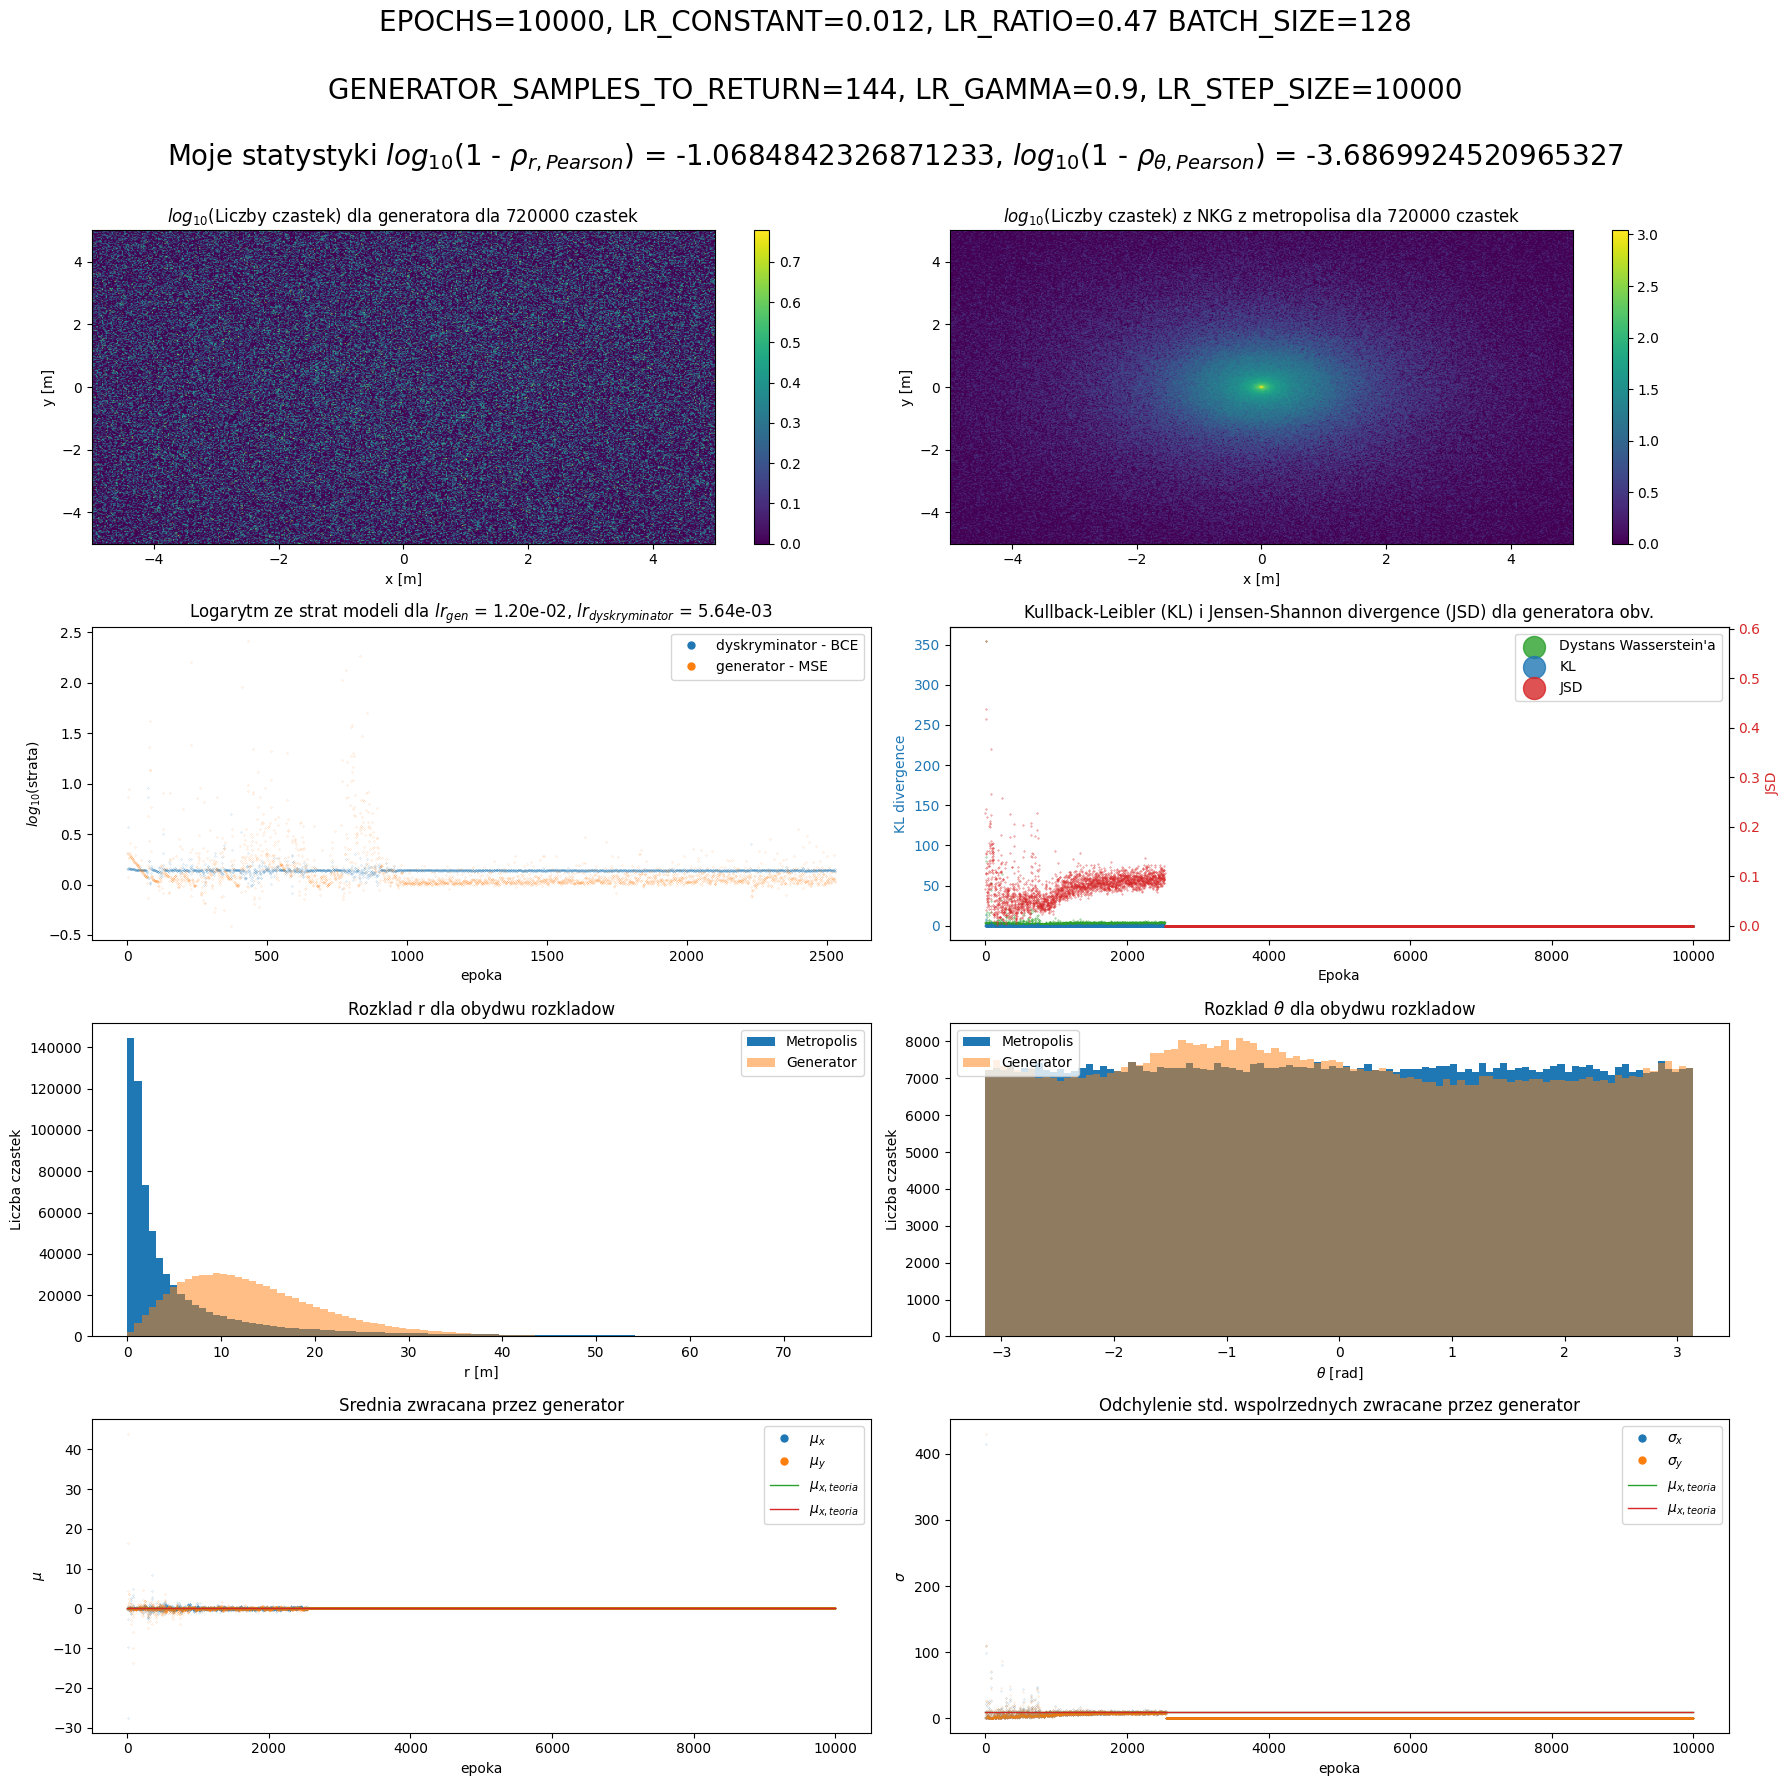

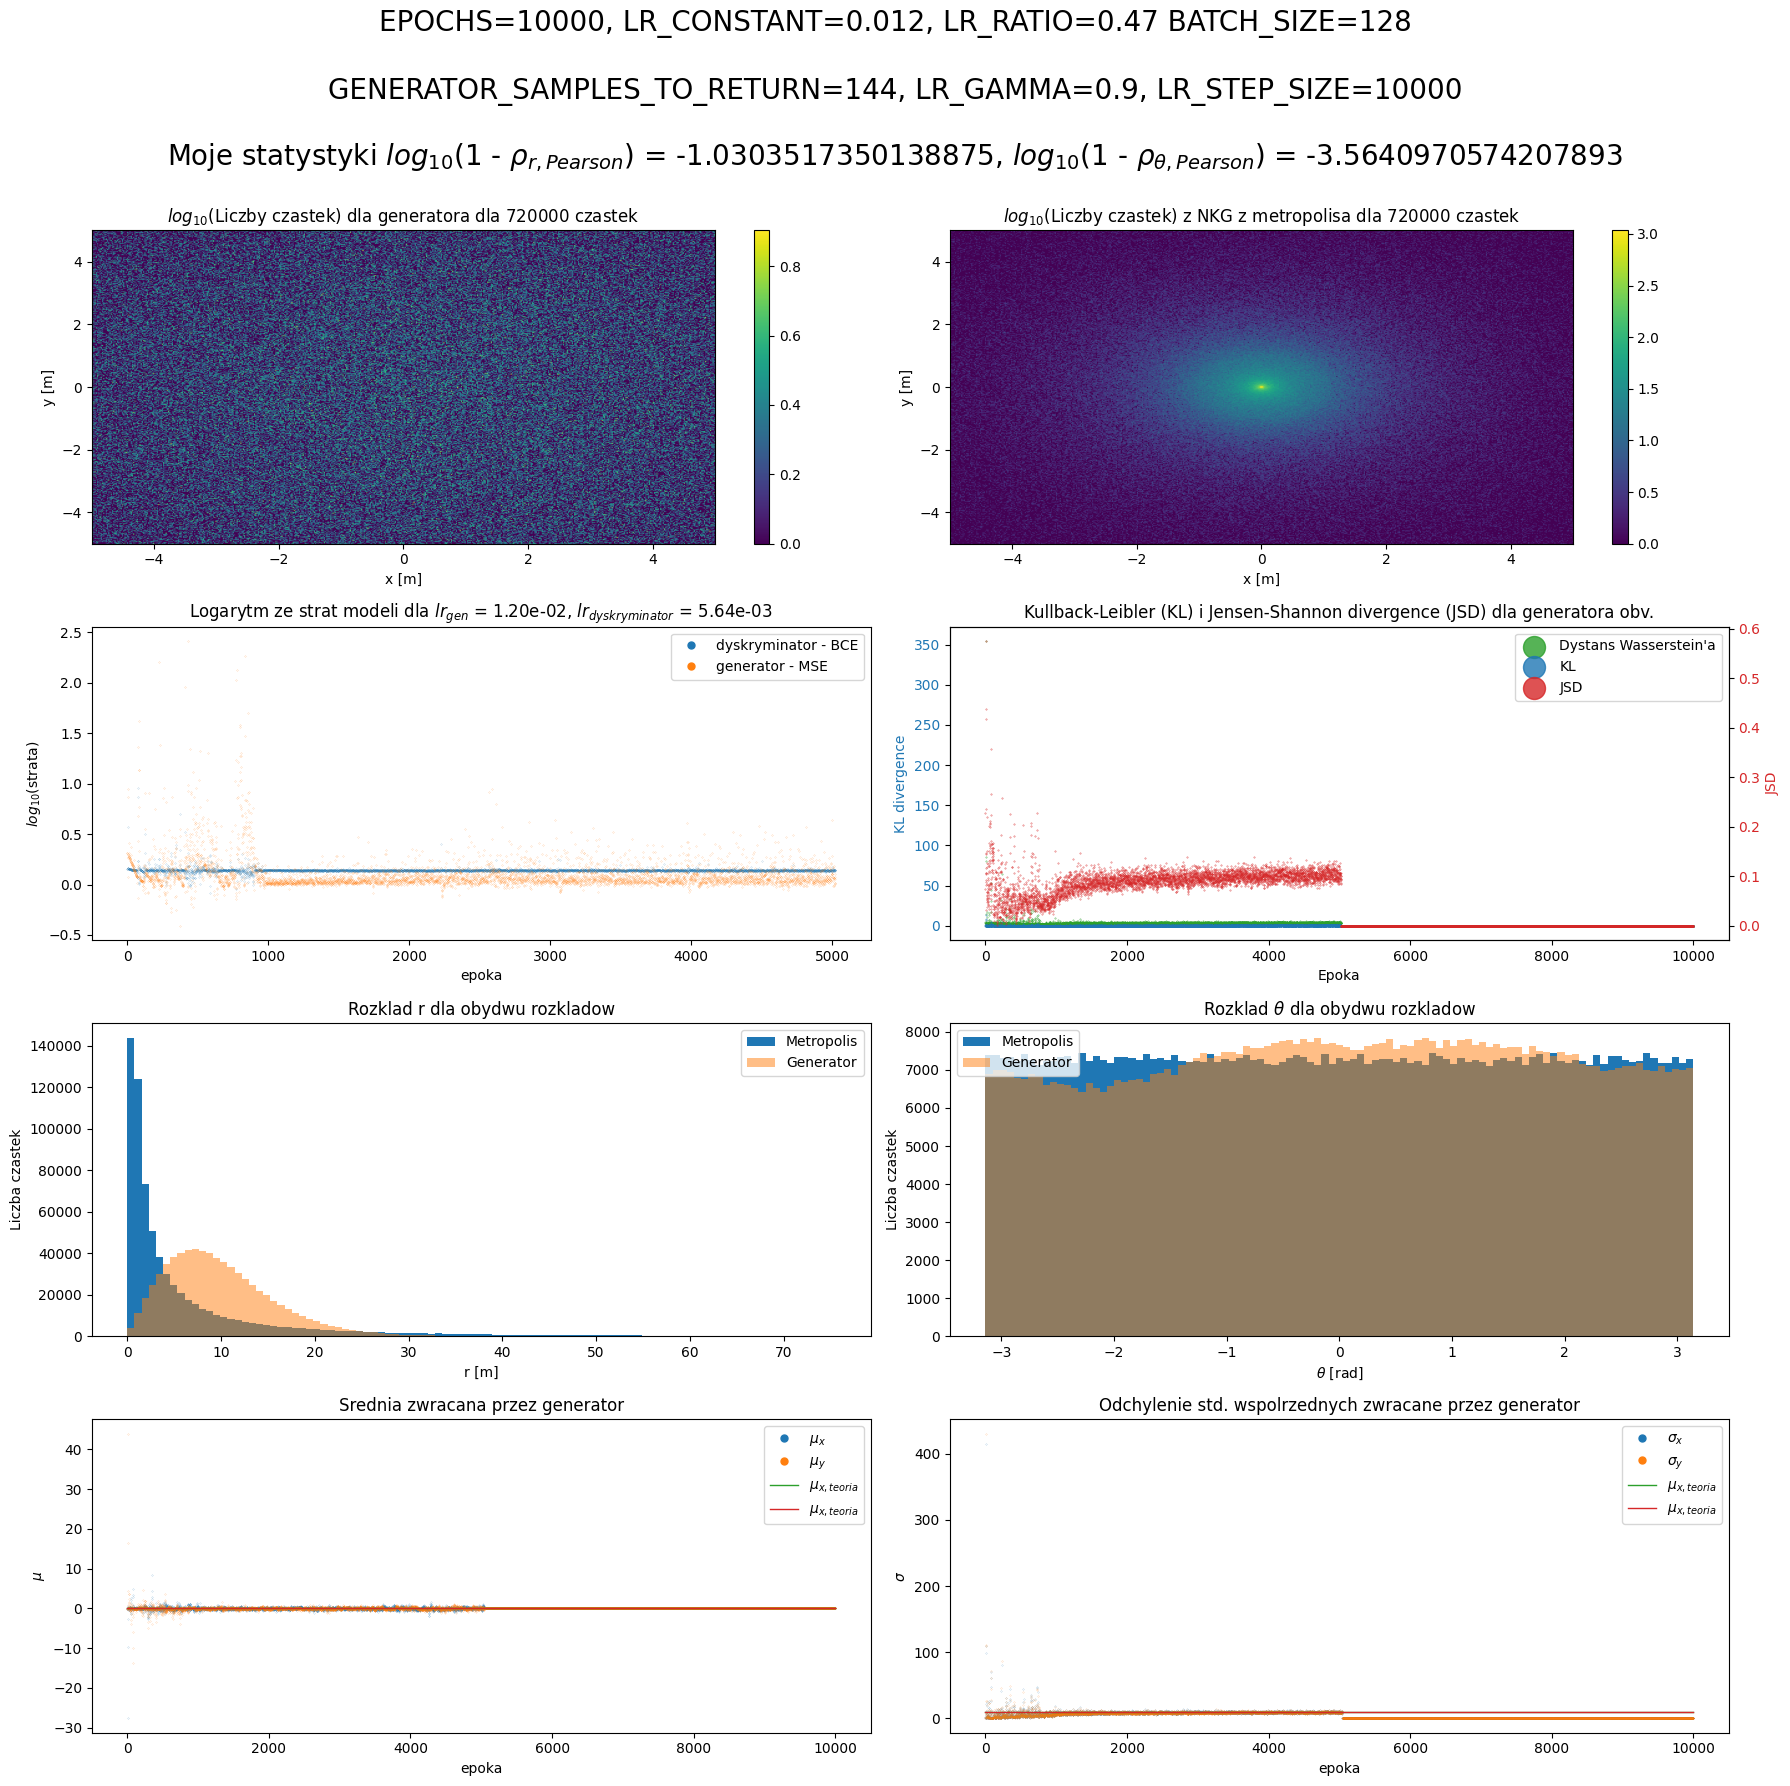

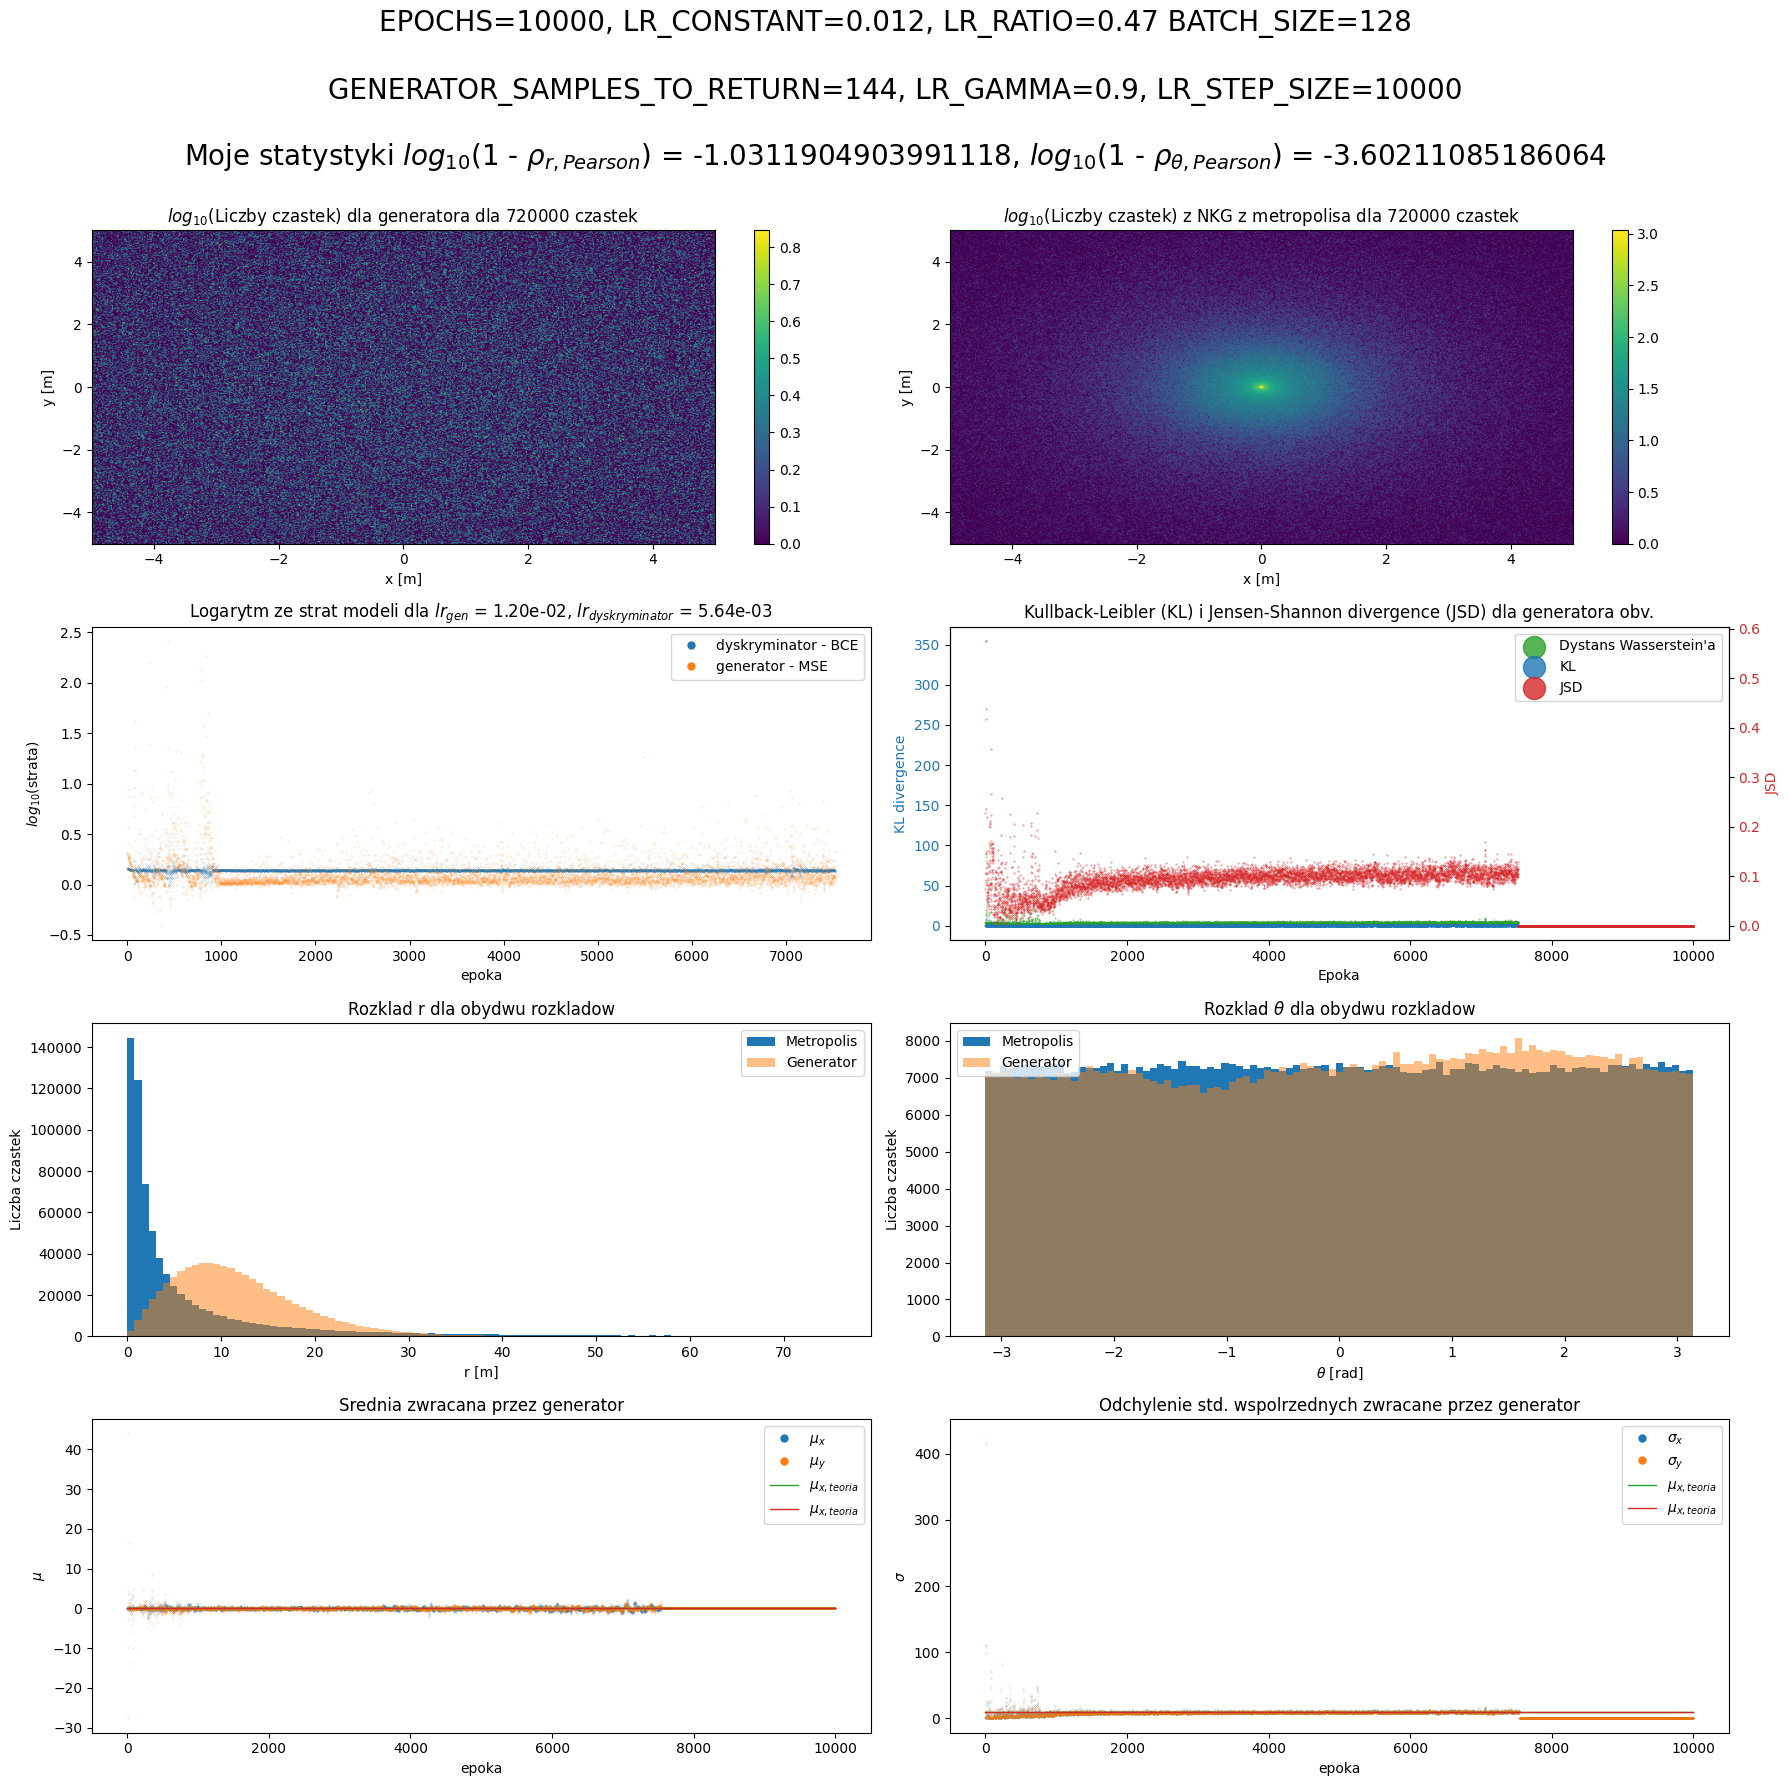

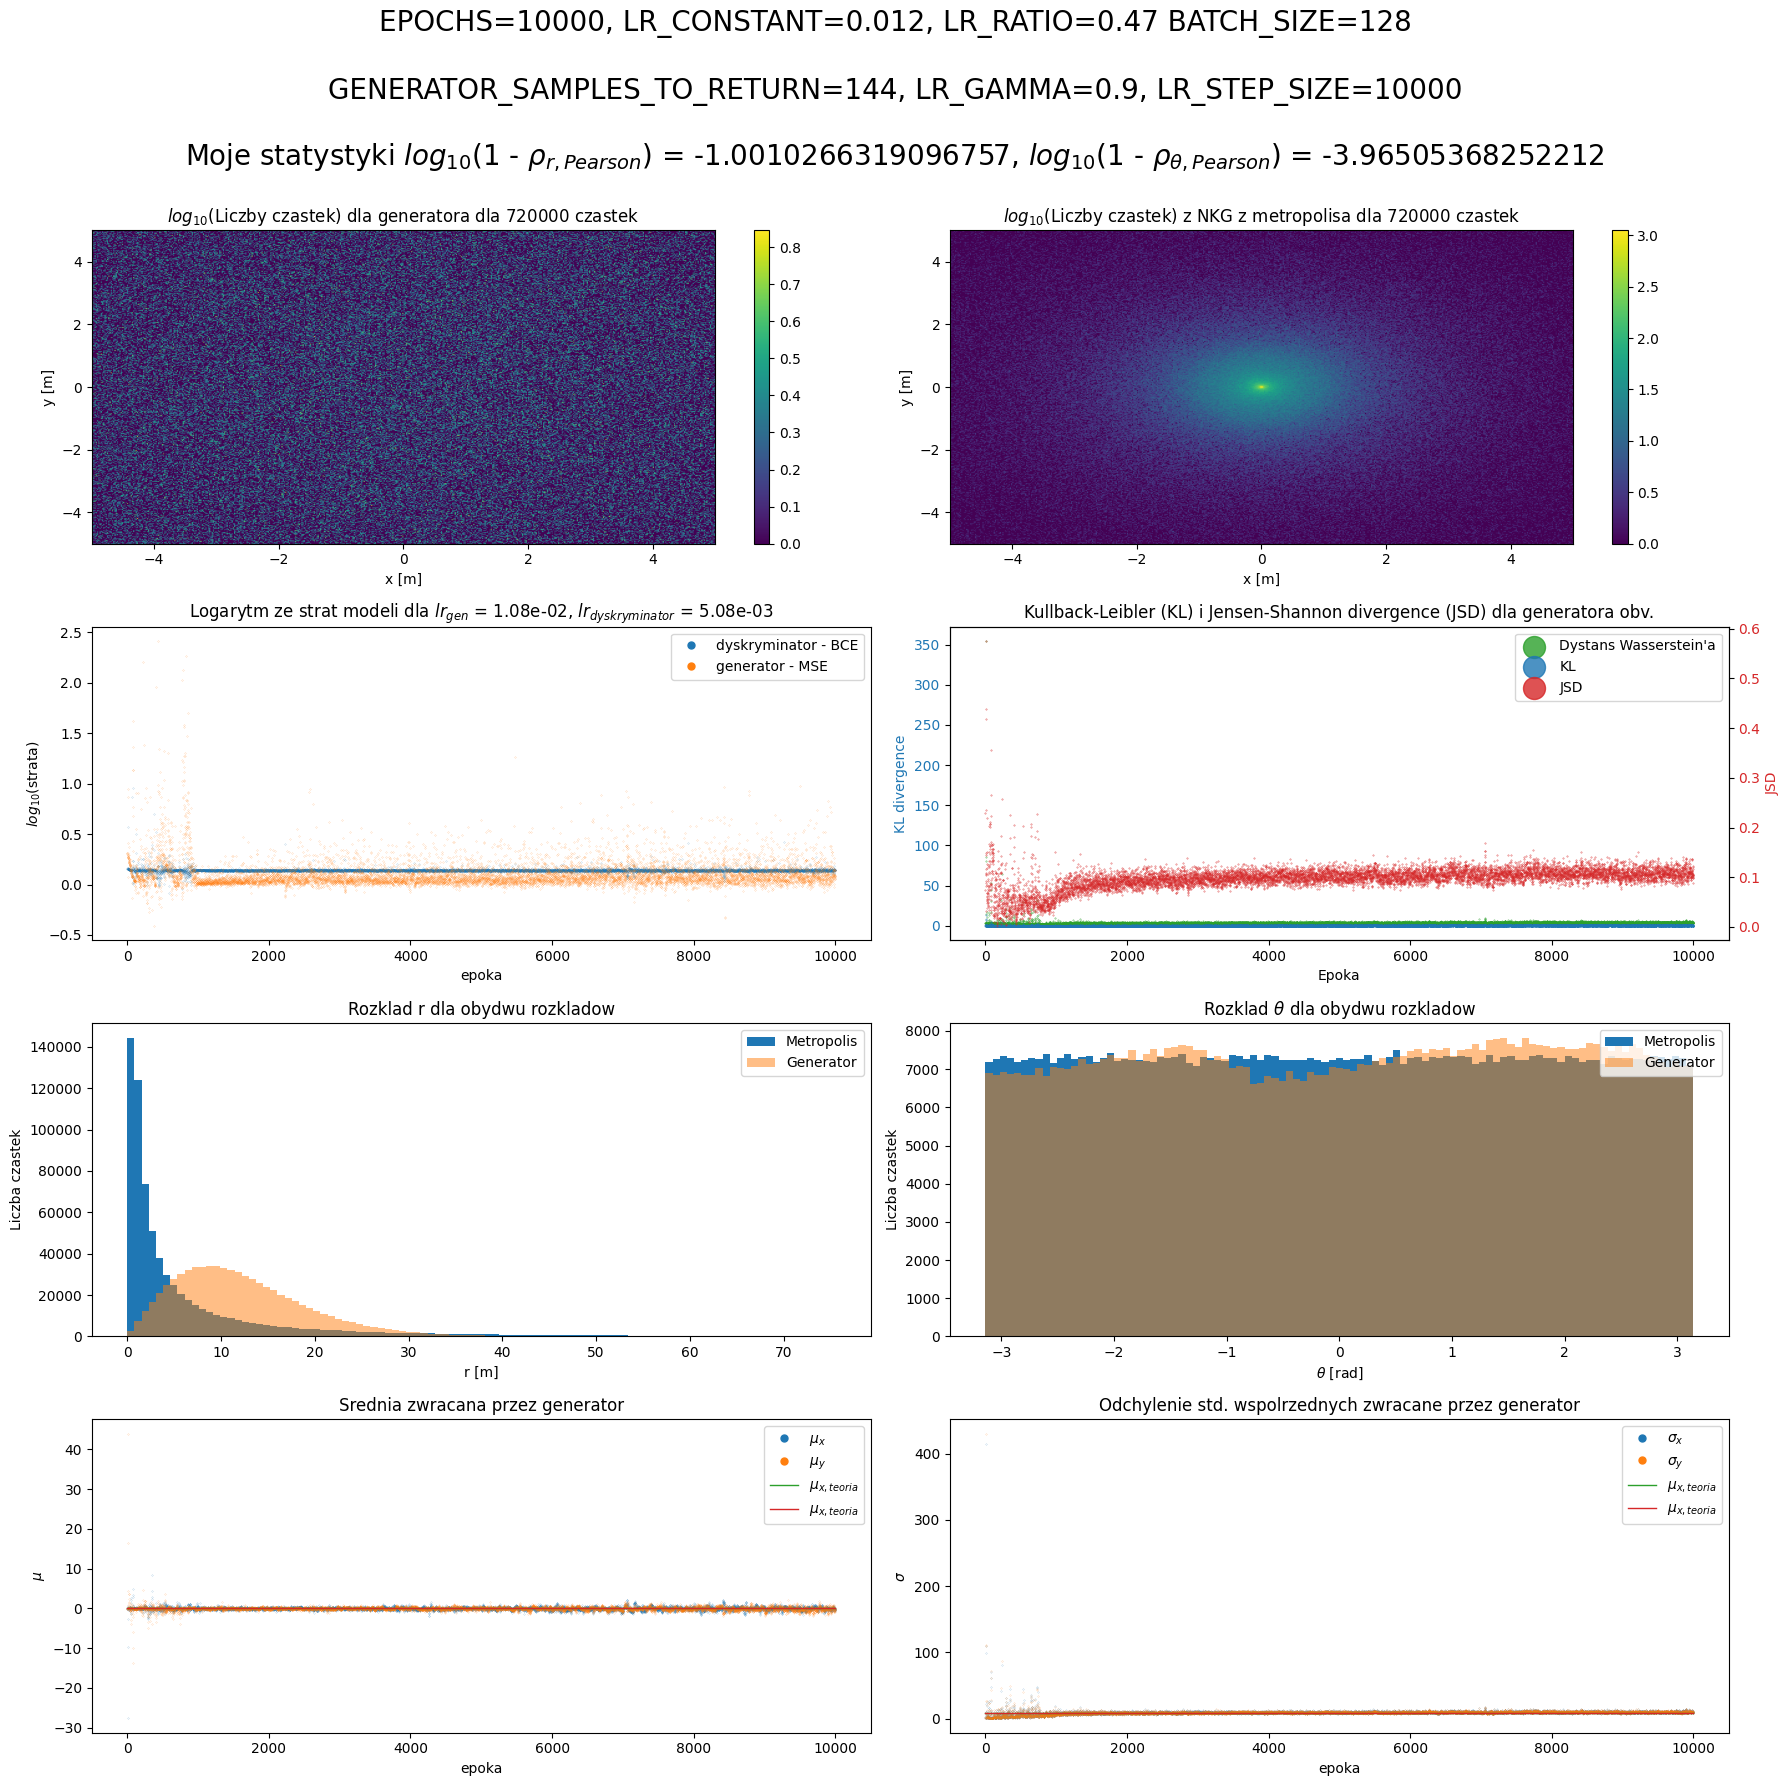

In [ ]:
import time
import threading
from concurrent.futures import ThreadPoolExecutor
torch.cuda.set_per_process_memory_fraction(0.9, device=0)

# Konfiguracja
EPOCHS = 10_000 #* Jakies 6000 epok / min
LR_CONSTANT = 1.2e-2
LR_STEP_SIZE = EPOCHS
LR_GAMMA = 0.9
LR_RATIO = 0.47 # LR_DYSKR / LR_GEN
BATCH_SIZE = 128
LATENT_DIM = 128
GENERATOR_SAMPLES_TO_RETURN = 144 # moze zwiekszyc
EXTRA_STATS_ADDED = 4

# for LR_RATIO in np.linspace(0.5, 1.3, num=4):
lock = threading.Lock()
torch.manual_seed(42)
np.random.seed(42)

x_mean_history, y_mean_history = np.zeros(EPOCHS), np.zeros(EPOCHS)
x_stdev_history, y_stdev_history = np.zeros(EPOCHS), np.zeros(EPOCHS)
generator_losses, discriminator_losses = np.zeros(EPOCHS), np.zeros(EPOCHS)
KL, JSD, Wasserstein_distance = np.zeros(EPOCHS), np.zeros(EPOCHS), np.zeros(EPOCHS)

generator_layers = [ #! Bez batchy lepszy jest ten generator
    nn.Linear(LATENT_DIM, 144), nn.LeakyReLU(0.2),
    nn.Linear(144, 168),        nn.LeakyReLU(0.2),
    nn.Linear(168, 192),        nn.LeakyReLU(0.2),
    nn.Linear(192, 192),        nn.LeakyReLU(0.2),
    nn.Linear(192, 192),        nn.LeakyReLU(0.2),
    nn.Linear(192, GENERATOR_SAMPLES_TO_RETURN, bias=False)
]
generator = Generator(generator_layers, LR_CONSTANT, BATCH_SIZE, LATENT_DIM, LR_GAMMA, LR_STEP_SIZE)

discriminator_layers = [ #! Nie mysl o sigmoidzie na koncu
    nn.Linear(GENERATOR_SAMPLES_TO_RETURN + EXTRA_STATS_ADDED, 256),
    nn.Linear(256, 128),    nn.LeakyReLU(0.2),
    nn.Linear(128, 64),     nn.LeakyReLU(0.2),
    nn.Linear(64, 32),      nn.LeakyReLU(0.2),
    nn.Linear(32, 16),      nn.LeakyReLU(0.2),
    nn.Linear(16, 8),       nn.LeakyReLU(0.2),
    nn.Linear(8,  4),       nn.LeakyReLU(0.2),
    nn.Linear(4,  2),       nn.LeakyReLU(0.2),
    nn.Linear(2,  1),
]
discriminator = Discriminator(discriminator_layers, LR_CONSTANT * LR_RATIO, LR_GAMMA, LR_STEP_SIZE)

generator.train()
generator.compile()
discriminator.train()
discriminator.compile()

"""
Idee:
    #1 Musza istniec stale ktore zadzialaja dla modelu - moze bedzie sie uczyc wolno ale na pewno sa takie stale
    #2 Zobaczyc co sie dzieje kiedy dyskryminator i generator maja podobne straty, w teorii to powinno sie uczyc najszybciej moze zignorowac ten wykresz KL i JSD 
    #3 Jak najwiecej pisac
    #4 Zmierzyc czas co ile zajmuje i optymalizowac
    #5 Jak i gdzie tutaj wsadzic JSD i KL ? 
"""

epoch = 0

def add_stats(data_tensor: torch.Tensor, epoch: int = None):
    tensor_view = data_tensor.view(BATCH_SIZE, -1, 2)
    means = tensor_view.mean(dim=1)  # (batch, 2)
    stds = tensor_view.std(dim=1)    # (batch, 2)
    
    result = torch.cat([data_tensor, means, stds], dim=1)
    
    if epoch is not None: # a new 
        x_mean_history[epoch] = means[:, 0].mean().cpu()
        y_mean_history[epoch] = means[:, 1].mean().cpu()
        x_stdev_history[epoch] = stds[:, 0].mean().cpu()
        y_stdev_history[epoch] = stds[:, 1].mean().cpu()
    
    return result

def gather_stats(true_data, fake_data, epoch):
    with lock:
        true_data_np = true_data.reshape(-1, 1).cpu().detach().numpy()
        fake_data_np = fake_data.reshape(-1, 1).cpu().detach().numpy()

    progress = epoch / EPOCHS
    filled = int(200 * progress)
    bar = '█' * filled + '░' * (200 - filled)
    print(f'\rTrening [{bar}] ({progress*100:5.1f}%)', end='', flush=True)

    KL[epoch], JSD[epoch] = fast_kl_jsd_2d(true_data_np, fake_data_np)
    Wasserstein_distance[epoch] = wasserstein_distance(fake_data_np.reshape(-1,), true_data_np.reshape(-1,))

    if epoch % 2_500 == 0 and epoch != 0:
        plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, LR_GAMMA, LR_STEP_SIZE, epoch, f'\nTrening_dla_{LR_RATIO=}_{epoch=}_{LR_STEP_SIZE=}')

def create_noise_and_data():
    noise = torch.randn(BATCH_SIZE, LATENT_DIM).cuda()
    data = get_2d_data(BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN)
    return noise, data

noise, data = create_noise_and_data()

with ThreadPoolExecutor(max_workers=4) as executor:
    while epoch < EPOCHS:
        fake_data = generator.layers(noise).detach()
        fake_data =  add_stats(fake_data, epoch)

        true_data = torch.FloatTensor(data).cuda().reshape(BATCH_SIZE, GENERATOR_SAMPLES_TO_RETURN)
        true_data = add_stats(true_data)

        # Trening
        discriminator_losses[epoch] = discriminator.training_step(true_data, fake_data)
        generator_losses[epoch] = generator.training_step(noise)

        # rozjazd watkow
        executor.submit(gather_stats, true_data, fake_data, epoch)
        data_future = executor.submit(create_noise_and_data)
        
        noise, data = data_future.result()  # Czeka na dane

        epoch += 1
        
        if lock.locked():
            time.sleep(0.003)

bar = '█' * 200
print(f'\rTrening [{bar}] {epoch:4d}/{EPOCHS} ({100:5.1f}%)\n', end='', flush=True)
print(f'\n{LR_RATIO=}\n')

plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, LR_GAMMA, LR_STEP_SIZE, EPOCHS, EPOCHS, f'\nTrening_dla_{LR_RATIO=}_{EPOCHS=}_{LR_STEP_SIZE=}')

In [ ]:
plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, '\nNajlepszy model poki co')
torch.save(discriminator.state_dict(), "best_discriminator_so_far.pth")
torch.save(generator.state_dict(), 'best_generator_so_far.pth')

TypeError: plot_basic_stats() missing 2 required positional arguments: 'LR_GAMMA' and 'LR_STEP_SIZE'

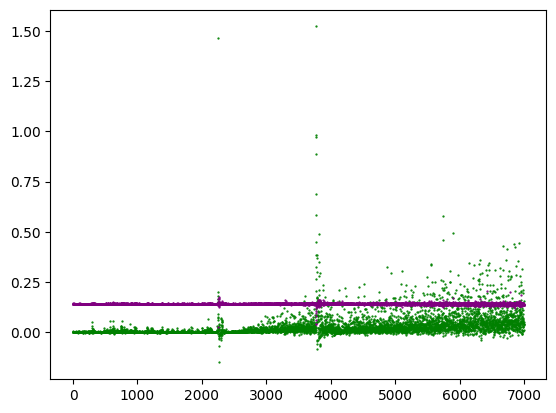

In [67]:
plt.plot(np.log10( generator_losses[3_000:] ), 'o', markersize=0.6, color='green')
plt.plot(np.log10( discriminator_losses[3_000:] ), 'o', markersize=0.6, color='purple')